# ML modeling: TF-IDF & Random Forest

### Description
We are using a data set of 1.6 million tweets labelled 'positive' or 'negative', to train a model

bag-of-words algorithm. 

* The simple bag-of-words based classification: use TF-IDF as embedding in combination with Random Forest as classifier. 


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# from sklearn.metrics import roc_curve, auc
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer 
# from nltk.tokenize import RegexpTokenizer
# from collections import Counter

import re
# import string

# import tensorflow as tf
# from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing import sequence
# from keras.preprocessing.sequence import pad_sequences

pd.set_option('max_colwidth',150)

### A peek at the data set

In [2]:
raw_data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin-1',
                       names=['target', 'ids', 'date', 'flag', 'user', 'text'])
raw_data.head(3)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds


In [5]:
raw_data['target'].unique()

array([0, 4], dtype=int64)

Text(0.5, 1.0, 'Tweet Sentiment')

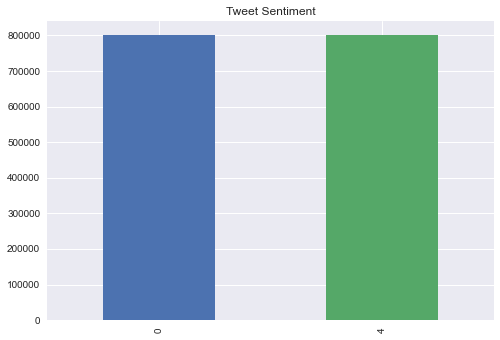

In [4]:
raw_data['target'].value_counts().plot(kind='bar', color=['C0','C1']); plt.title('Tweet Sentiment')

In [3]:
# Drop unused columns
raw_data.drop(['ids', 'date', 'flag', 'user'], axis=1, inplace=True)

In [9]:
def data_cleaner(tweet):
    # lower text
    tweet = tweet.lower()
    
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    
    # remove tweets containing digits
    tweet = re.sub('\w*\d\w*', ' ', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    
    # remove anything not a letter
    tweet = re.sub(r'\W+', ' ', tweet)
    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    
    return tweet


stop_words = stopwords.words('english')

raw_data['cleaned_text'] = raw_data['text'].apply(data_cleaner)


In [10]:
raw_data.to_csv('raw_clean.csv', encoding='utf-8', index=False)

In [11]:
cleaned_df = pd.read_csv('raw_clean.csv')

In [12]:
cleaned_df.head(3)

,target,text,cleaned_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",awww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset update facebook texting might cry result school today also blah
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived many times ball managed save rest go bounds


In [13]:
# Label the attitude column
cleaned_df['target'] = np.where(cleaned_df['target']==4, 1, 0)

# Confirm the labels
cleaned_df.groupby('target').count()

,text,cleaned_text
target,,
0,800000,795983
1,800000,795758


In [39]:
data = cleaned_df[['target', 'cleaned_text']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   target        1600000 non-null  int32 
 1   cleaned_text  1591741 non-null  object
dtypes: int32(1), object(1)
memory usage: 18.3+ MB


In [40]:
data.isnull().sum()

target             0
cleaned_text    8259
dtype: int64

In [41]:
# Drop all null values
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1591741 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   target        1591741 non-null  int32 
 1   cleaned_text  1591741 non-null  object
dtypes: int32(1), object(1)
memory usage: 30.4+ MB


## Remove outliers

In [19]:
from textblob import TextBlob

In [42]:
data['polarity'] = data['cleaned_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

<AxesSubplot:title={'center':'polarity'}, xlabel='target'>

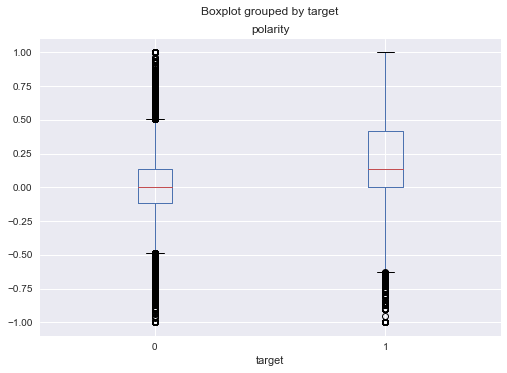

In [46]:
# Relative distribution of polarity, grouped by target labels
data.boxplot(column='polarity', by='target')

In [64]:
data.groupby('target').describe()

polarity                                                            
           count      mean       std  min       25%       50%       75%  max
target                                                                      
0       795983.0 -0.008557  0.326721 -1.0 -0.114792  0.000000  0.133333  1.0
1       795758.0  0.205245  0.310519 -1.0  0.000000  0.136364  0.416667  1.0

In [62]:
# data.to_csv('before_outlier.csv', index=False, encoding='utf-8')
data = pd.read_csv('before_outlier.csv')

In [65]:
data_neg = data[(data['target']==0) & (data['polarity']<0.14)]
data_pos = data[(data['target']==1) & (data['polarity']>0)]

In [71]:
data_neg.head()

,target,cleaned_text,polarity
1,0,upset update facebook texting might cry result school today also blah,0.000
4,0,behaving mad see,-0.625
6,0,need hug,0.000
8,0,nope,0.000
9,0,que muera,0.000


In [75]:
data_f = pd.concat([data_neg, data_pos], ignore_index=True)
data_f.tail()

,target,cleaned_text,polarity
1047577,1,woke school best feeling ever,1.000
1047578,1,thewdb com cool hear old walt interviews â,0.225
1047579,1,ready mojo makeover ask details,0.200
1047580,1,happy birthday boo alll time tupac amaru shakur,0.800
1047581,1,happy,0.800


In [4]:
data_f.to_csv('aftertexblobIQR.csv', index=False)

In [5]:
data = pd.read_csv('aftertexblobIQR.csv')
data.head()

,target,cleaned_text,polarity
0,0,upset update facebook texting might cry result school today also blah,0.000
1,0,behaving mad see,-0.625
2,0,need hug,0.000
3,0,nope,0.000
4,0,que muera,0.000


## Modeling with TF-IDF and RF classifier

In [94]:
data = data.sample(n=100000, random_state=1)
data.shape

(100000, 3)

In [95]:
from sklearn.model_selection import train_test_split

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'],
                                                    data['target'], test_size=0.2)

In [99]:
X_train

924132                    melbourne mazda new ad received posted hcc site soon
410794                                                        almost wtf class
198562                big fan replaced mine twice one randomly resetting month
523888                                                  well way davids bridal
795450                            home seeing pixar cute go see right tomorrow
                                          ...                                 
942730    oh see thanks well friends soon hopefully get back work thankyou xxx
62148                                                     got booted limelight
552478                                                         come never hang
91521                    im tired cant sleep makes officially screwed tomorrow
307491                                                           least episode
Name: cleaned_text, Length: 80000, dtype: object

### Make a pipeline

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score

# Instantiate and fit a TFIDF vectorizer and then use that trained vectorizer
# to transform the messages in the training and test sets
tfidf_vect = TfidfVectorizer()
rf = RandomForestClassifier(random_state=10, n_estimators=50, n_jobs=-1)
pipeline = make_pipeline(tfidf_vect, rf)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                        random_state=10))])

In [97]:
# Use the trained model to make predictions on the test data
y_pred = pipeline.predict(X_test)

In [98]:
# Evaluate the predictions of the model on the holdout test set
from sklearn.metrics import precision_score, recall_score, accuracy_score

precision = precision_score(y_test, y_pred, average="binary")
recall = recall_score(y_test, y_pred, average="binary")
accurate = accuracy_score(y_test, y_pred)
print('Precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accurate)

Precision:  0.9231773925433389
recall:  0.9143831588850994
accuracy:  0.93125


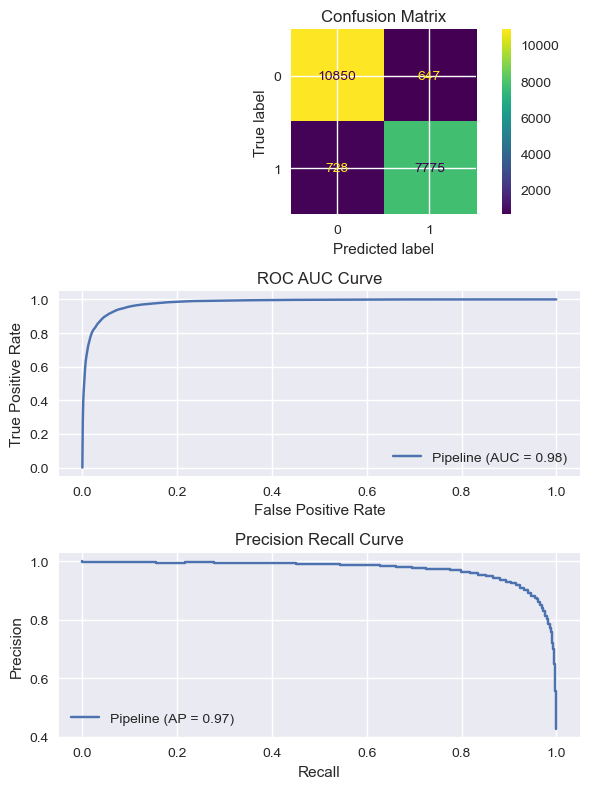

In [104]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve, precision_recall_curve
from sklearn.model_selection import KFold, cross_val_score

fig, axes = plt.subplots(nrows=3, ncols=1, dpi=100, figsize=(6,8))
plot_confusion_matrix(pipeline, X_test, y_test, ax=axes[0])
axes[0].set_title('Confusion Matrix')
plot_roc_curve(pipeline, X_test, y_test, ax=axes[1])
axes[1].set_title('ROC AUC Curve')
plot_precision_recall_curve(pipeline, X_test, y_test,ax=axes[2])
axes[2].set_title('Precision Recall Curve')
plt.tight_layout()

### 5-fold cross validation

In [100]:
# 5-fold cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator = pipeline,
                       X=X_train, y=y_train,
                       cv=5, n_jobs=-1)
print(f'CV accuracy scores: {scores}')
print('-----------------')
print(f'cv accuracy {np.mean(scores): .3f} +/- {np.std(scores): .3f}')

CV accuracy scores: [0.9235625 0.9255    0.92575   0.923875  0.926125 ]
-----------------
cv accuracy  0.925 +/-  0.001


### Apply for full-scale dataset

In [6]:
data.shape

(1047582, 3)

In [7]:
from sklearn.model_selection import train_test_split

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'],
                                                    data['target'], test_size=0.2)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# Instantiate and fit a TFIDF vectorizer and then use that trained vectorizer
# to transform the messages in the training and test sets
tfidf_vect = TfidfVectorizer()
rf = RandomForestClassifier(random_state=10, n_estimators=50, n_jobs=-1)
pipeline = make_pipeline(tfidf_vect, rf)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                        random_state=10))])

In [9]:
# Use the trained model to make predictions on the test data
y_pred = pipeline.predict(X_test)

In [10]:
# Evaluate the predictions of the model on the holdout test set
from sklearn.metrics import precision_score, recall_score, accuracy_score

precision = precision_score(y_test, y_pred, average="binary")
recall = recall_score(y_test, y_pred, average="binary")
accurate = accuracy_score(y_test, y_pred)
print('Precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accurate)

Precision:  0.9403431809354079
recall:  0.9250826046887994
accuracy:  0.9432599741309774


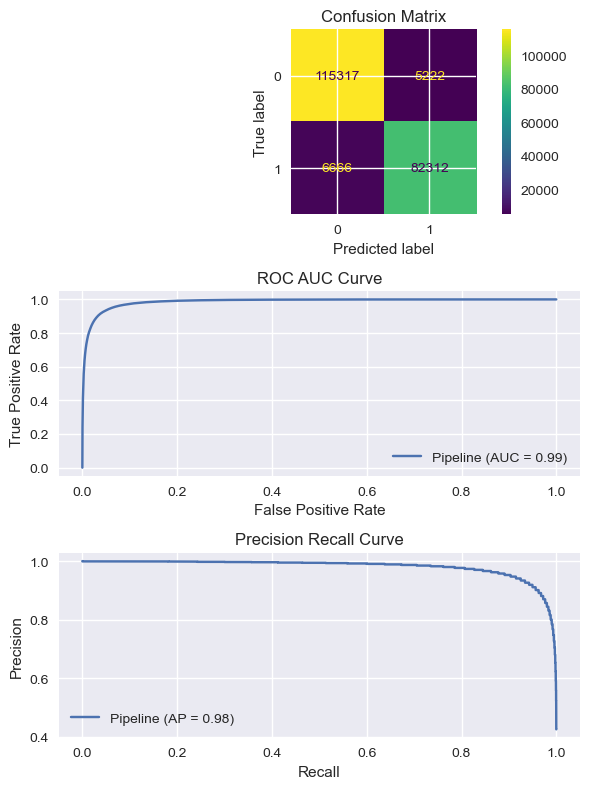

In [11]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve, precision_recall_curve
from sklearn.model_selection import KFold, cross_val_score

fig, axes = plt.subplots(nrows=3, ncols=1, dpi=100, figsize=(6,8))
plot_confusion_matrix(pipeline, X_test, y_test, ax=axes[0])
axes[0].set_title('Confusion Matrix')
plot_roc_curve(pipeline, X_test, y_test, ax=axes[1])
axes[1].set_title('ROC AUC Curve')
plot_precision_recall_curve(pipeline, X_test, y_test,ax=axes[2])
axes[2].set_title('Precision Recall Curve')
plt.tight_layout()

In [12]:
# Save and compress the model
import joblib
joblib.dump(pipeline, 'tfidf_rf_pipeline_full.sav', compress=3)

['tfidf_rf_pipeline_full.sav']